## IMPORT ALL NECESSARY LIBRARIES

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
from torch import nn
from torchvision import models

## DEFINE THE CUSTOM MODEL CLASS

In [3]:
class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()

        # Load pre-trained ResNeXt50 model and remove the last few layers

        model = models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        
        # Define an LSTM layer for sequence processing

        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
         
         # Reshape input for feature extraction

        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        
        # Apply average pooling

        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        
        # Process sequence with LSTM and apply dropout

        x_lstm, _ = self.lstm(x, None)
        return fmap, self.dp(self.linear1(x_lstm[:, -1, :]))

## IMAGE NORMALIZATION PARAMETERS

In [4]:
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize = transforms.Normalize(mean=-1 * np.divide(mean, std), std=np.divide([1, 1, 1], std))

def im_convert(tensor):    
    # Convert a tensor to an image and save it.
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1, 2, 0)
    image = image.clip(0, 1)
    cv2.imwrite('./2.png', image * 255)
    return image

def predict(model, img, path='./'):
    # Make a prediction on the given image.
    model.eval()  # Ensure the model is in evaluation mode
    fmap, logits = model(img.to('cpu'))
    params = list(model.parameters())
    weight_softmax = model.linear1.weight.detach().cpu().numpy()
    logits = sm(logits)
    _, prediction = torch.max(logits, 1)
    confidence = logits[:, int(prediction.item())].item() * 100
    print('confidence of prediction:', confidence)
    idx = np.argmax(logits.detach().cpu().numpy())
    bz, nc, h, w = fmap.shape
    # Generate heatmap for visualization
    out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h * w)).T, weight_softmax[idx, :].T)
    predict = out.reshape(h, w)
    predict = predict - np.min(predict)
    predict_img = predict / np.max(predict)
    predict_img = np.uint8(255 * predict_img)
    out = cv2.resize(predict_img, (im_size, im_size))
    heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
    img = im_convert(img[:, -1, :, :, :])
    # Combine heatmap with original image
    result = heatmap * 0.5 + img * 0.8 * 255
    cv2.imwrite('/content/1.png', result)
    result1 = heatmap * 0.5 / 255 + img * 0.8
    r, g, b = cv2.split(result1)
    result1 = cv2.merge((r, g, b))
    plt.imshow(result1)
    plt.show()
    return [int(prediction.item()), confidence]

## DEFINE A CUSTOM DATASET CLASS FOR VIDEO FRAMES

In [5]:
class validation_dataset(Dataset):
    def __init__(self, video_names, sequence_length=60, transform=None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100 / self.count)
        first_frame = np.random.randint(0, a)
        for i, frame in enumerate(self.frame_extract(video_path)):
            faces = face_recognition.face_locations(frame)
            try:
                top, right, bottom, left = faces[0]
                frame = frame[top:bottom, left:right, :]
            except:
                pass
            frames.append(self.transform(frame))
            if len(frames) == self.count:
                break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)

    def frame_extract(self, path):
        """Extract frames from the video."""
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image

def im_plot(tensor):
    """Plot a tensor as an image."""
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    b, g, r = cv2.split(image)
    image = cv2.merge((r, g, b))
    image = image * [0.22803, 0.22145, 0.216989] + [0.43216, 0.394666, 0.37645]
    image = image * 255.0
    plt.imshow(image.astype(int))
    plt.show()


## IMAGE TRANSFORMATIONS

c:\Users\sarat\anaconda3\envs\env1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sarat\anaconda3\envs\env1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\sarat\AppData\Local\Temp\ipykernel_36164\2164963497.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.c

t2.mp4


c:\Users\sarat\anaconda3\envs\env1\lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


confidence of prediction: 76.04802250862122


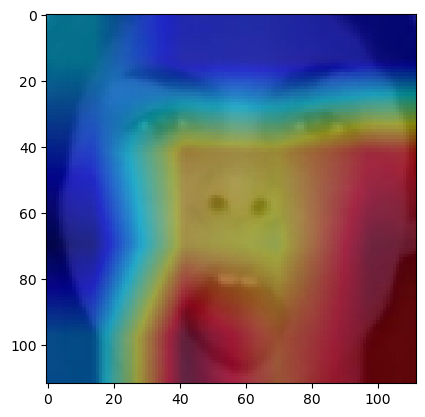

REAL


In [6]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load video dataset and model
path_to_videos = ['t2.mp4']

video_dataset = validation_dataset(path_to_videos, sequence_length=20, transform=train_transforms)
model = Model(2).to('cpu')
path_to_model = 'model_84_acc_10_frames_final_data.pt'
model.load_state_dict(torch.load(path_to_model, map_location='cpu'))
model.eval()

# Make predictions on the video(s)
for i in range(len(path_to_videos)):
    print(path_to_videos[i])
    prediction = predict(model, video_dataset[i], './')
    if prediction[0] == 1:
        print("REAL")
    else:
        print("FAKE")